<a href="https://colab.research.google.com/github/Bilpapster/Neural-Networks/blob/main/1a_KNN_and_Nearest_Centroid_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intermediate assignment in Neural Networks - Deep Learning

> Vasileios Papastergios (ID: 3651)


---


# Introduction

The current Jupiter Notebook contains python source code for the first intermediate assignment in the course of [Neural Networks - Deep Learing](https://qa.auth.gr/en/x/class/1/600237255). The author attended the course during their 7th semester of studies at the [Aristotle University of Thessaloniki (AUTH)](https://www.csd.auth.gr/en/).

The first intermediate assignment focuses on selecting a dataset and implementing basic non-neural-networks classifying techniques for multiclass classification.We have selected to work with the [Intel Image Classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data) dataset, which was found on [Kaggle](https://www.kaggle.com/datasets). The dataset consists of a train set (14K images) and a test set (3K images) of images that belong to one of the 6 (mutually exclusive) following classes:
1. buildings
2. forest
3. glacier
4. mountain
5. sea
6. street

We use the training set to train three classification models, in order to compute and compare their performance. In particular, we investigate the performance of the following three models:
- a K-nearest neighbors classifier, for K=1 neighbor
- a K-nearest neighbors classifier, for K=3 neighbors
- a nearest centroid classifier

Below, we present the series of steps we have taken throughout our investigation, starting from the preliminary ones towards the core steps of training the classifiers and measuring their performance.


# A. Preliminary steps

Before diving into the "actual" tasks of the assignment, we need to take some preliminary steps.

## A.1. Necessary imports

At first, we import several libraries that we are going to use later on this assignment. Furthermore, we mount the Google Drive storage. This enables us to download and store the Kaggle dataset in our Google Drive and handle it conveniently.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## A.2. Downloading the dataset

In the following cell we configure the environment variable and download the [Intel Image Classification dataset](https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data) into our Google Drive. The dataset is downloaded as a .zip file, so we need to unzip it and then remove the .zip file, since it is no longer needed.

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/gdrive/My Drive/Kaggle"
%cd /gdrive/My Drive/Kaggle
%pwd
!kaggle datasets download -d puneet6060/intel-image-classification
%ls
!unzip /*.zip && !rm /*.zip

/gdrive/My Drive/Kaggle
classes_frequency_dict.pkl  image_shapes_frequency_dict.pkl  plots/     seg_test/   test.csv
classifiers/                kaggle.json                      seg_pred/  seg_train/  train.csv


## A.3. Creating a convenient train.csv file

If we take a closer look into the extracted directories, we can easily find out that the path /gdrive/My Drive/Kaggle/seg_train/seg_train/ contains the training set images. In particular, there are 6 sub-directories inside that path, one for every class of the multiclass classification problem with respective names:

1. buildings
2. forest
3. glacier
4. mountain
5. sea
6. street

We would like to use this observation in order to create a convenient
```train.csv```
file. More specifically, we would like to have a .csv file that contains the full path for every training image, as well as the class label and the class number of it, **all in one place**. The following cells do these exact actions. At the end of this step, we write back to disk the
```train.csv```
file, so that we can access it more easily from now on. The  latter step (persistence of the .csv file) is optional and you can ommit it. In such a scenario, someone would need to construct it again, every time needed.



In [2]:
def get_file_list(directory):
  '''
  a utility function that gets a directory and recursively explores it
  returns a 2D array, containing records in the form [path, parent_directory_name]
  '''
  file_list = os.listdir(directory)
  all_files = []
  for entry in file_list:
    path = os.path.join(directory, entry)
    parent_directory = path.split('/')[-2]
    if os.path.isdir(path):
      all_files = all_files + get_file_list(path)
    else:
      all_files.append([path, parent_directory])
  return all_files

In [ ]:
# we use the utility function to get the full list of traning image paths,
# combined with the parent directory (class) name
# we print the first 5 records for better understanding

path = '/gdrive/My Drive/Kaggle/seg_train/seg_train/'
all_files_list = get_file_list(path)
print(np.shape(all_files_list))
all_files_list[0:5]

(14034, 2)


[['/gdrive/My Drive/Kaggle/seg_train/seg_train/buildings/19638.jpg',
  'buildings'],
 ['/gdrive/My Drive/Kaggle/seg_train/seg_train/buildings/1954.jpg',
  'buildings'],
 ['/gdrive/My Drive/Kaggle/seg_train/seg_train/buildings/19537.jpg',
  'buildings'],
 ['/gdrive/My Drive/Kaggle/seg_train/seg_train/buildings/19440.jpg',
  'buildings'],
 ['/gdrive/My Drive/Kaggle/seg_train/seg_train/buildings/19460.jpg',
  'buildings']]

(150, 150, 3)


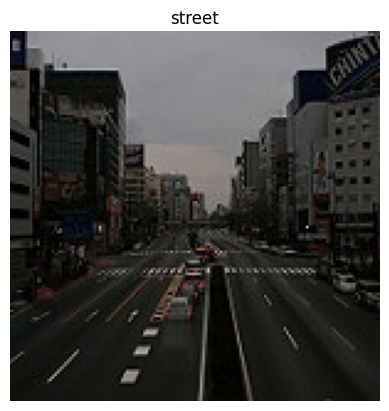

In [ ]:
# visualizing a random image of the training set to ensure
# that everything is alright

import random

random_index = random.randint(0, len(all_files_list) - 1)

image_path = all_files_list[random_index][0]
label = all_files_list[random_index][1]
image_array = plt.imread(image_path)
print(image_array.shape)
plt.imshow(image_array)
plt.axis('off')
plt.title(label)
plt.show()

In [ ]:
# displaying the top 5 rows of the constructed train data structure

train_data = pd.DataFrame(data = all_files_list, columns=['filepath', 'label_verbose'])
pd.set_option('display.max_colwidth', None)
train_data.head()

,filepath,label_verbose
0,/gdrive/My Drive/Kaggle/seg_train/seg_train/buildings/19638.jpg,buildings
1,/gdrive/My Drive/Kaggle/seg_train/seg_train/buildings/1954.jpg,buildings
2,/gdrive/My Drive/Kaggle/seg_train/seg_train/buildings/19537.jpg,buildings
3,/gdrive/My Drive/Kaggle/seg_train/seg_train/buildings/19440.jpg,buildings
4,/gdrive/My Drive/Kaggle/seg_train/seg_train/buildings/19460.jpg,buildings


In [ ]:
# writing the train data to a .csv file, adding information about the
# verbose version of the label, as well as the label number

labels_list = [
    "buildings",
    "forest",
    "glacier",
    "mountain",
    "sea",
    "street"
]

labels_dict = {label:index for index, label in enumerate(labels_list)}

train_data['label'] = train_data['label_verbose'].map(labels_dict)

train_data.to_csv('/gdrive/My Drive/Kaggle/train.csv',index=False)

## A.4. Explorative Analysis of the train data

In this subsection we explore the training data images. At first we load them from the newly created ```train.csv``` file and then we shuffle them. At this point we would like to point out that the ```random_state``` is set to a specific number (22), so that the shuffling is the same every time this cell is executed and the train data is loaded.

In [ ]:
labels_list = [
    "buildings",
    "forest",
    "glacier",
    "mountain",
    "sea",
    "street"
]

labels_dict = {label:index for index, label in enumerate(labels_list)}

train_data = pd.read_csv('/gdrive/My Drive/Kaggle/train.csv')
train_data = train_data.sample(frac=1., random_state=22)
train_data.head(10)

,filepath,label_verbose,label
6277,/gdrive/My Drive/Kaggle/seg_train/seg_train/gl...,glacier,2
12623,/gdrive/My Drive/Kaggle/seg_train/seg_train/st...,street,5
4314,/gdrive/My Drive/Kaggle/seg_train/seg_train/fo...,forest,1
4711,/gdrive/My Drive/Kaggle/seg_train/seg_train/gl...,glacier,2
10549,/gdrive/My Drive/Kaggle/seg_train/seg_train/se...,sea,4
5169,/gdrive/My Drive/Kaggle/seg_train/seg_train/gl...,glacier,2
5595,/gdrive/My Drive/Kaggle/seg_train/seg_train/gl...,glacier,2
3054,/gdrive/My Drive/Kaggle/seg_train/seg_train/fo...,forest,1
3468,/gdrive/My Drive/Kaggle/seg_train/seg_train/fo...,forest,1
2246,/gdrive/My Drive/Kaggle/seg_train/seg_train/fo...,forest,1


(150, 150, 3)


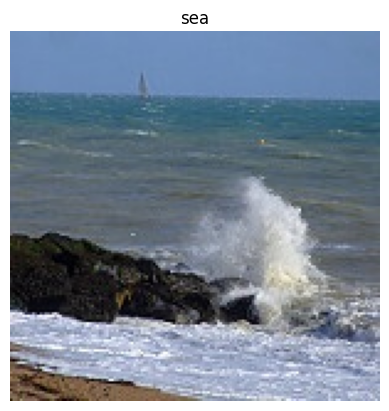

In [ ]:
# visualizing a random image of the training set to ensure
# that everything is alright
import random

random_index = random.randint(0, len(train_data['filepath']) - 1)

image_path = train_data['filepath'][random_index]
label = train_data['label_verbose'][random_index]
image_array = plt.imread(image_path)
print(image_array.shape)
plt.imshow(image_array)
plt.axis('off')
plt.title(label)
plt.show()

In the code that follows, we try to visualize the frequency of the images of each class in the train set, as well as the different image shapes of the train set. We produce two bar plots, one for the class support and one for the image shapes, as shown below. As we did before, we write the frequency dictionaries in main storage, in order to access them easier later on.

In [ ]:
# we create a dictionary containing the frequency of each class
# the goal is to plot the frequencies in a bar plot

classes_frequency_dict = {label: 0 for label in labels_list}
image_shapes_frequency_dict = {}

for row in range(len(train_data)):
  print(str(row))
  label_verbose = train_data['label_verbose'][row]
  classes_frequency_dict[label_verbose] += 1

  image_array = plt.imread(train_data['filepath'][row])
  image_shape_string = str(image_array.shape)
  image_shapes_frequency_dict[image_shape_string] = 1 if image_shape_string not in image_shapes_frequency_dict else image_shapes_frequency_dict[image_shape_string] + 1

print(classes_frequency_dict)
print(image_shapes_frequency_dict)

{'buildings': 2191, 'forest': 2271, 'glacier': 2404, 'mountain': 2512, 'sea': 2274, 'street': 2382}
{'(150, 150, 3)': 13986, '(124, 150, 3)': 1, '(136, 150, 3)': 2, '(108, 150, 3)': 2, '(113, 150, 3)': 7, '(133, 150, 3)': 1, '(115, 150, 3)': 1, '(135, 150, 3)': 3, '(76, 150, 3)': 1, '(97, 150, 3)': 1, '(111, 150, 3)': 3, '(120, 150, 3)': 1, '(149, 150, 3)': 1, '(143, 150, 3)': 2, '(146, 150, 3)': 2, '(134, 150, 3)': 2, '(123, 150, 3)': 2, '(142, 150, 3)': 2, '(119, 150, 3)': 1, '(102, 150, 3)': 1, '(110, 150, 3)': 1, '(105, 150, 3)': 1, '(100, 150, 3)': 1, '(141, 150, 3)': 1, '(145, 150, 3)': 1, '(81, 150, 3)': 1, '(147, 150, 3)': 1, '(131, 150, 3)': 1, '(144, 150, 3)': 2, '(103, 150, 3)': 1, '(140, 150, 3)': 1}


In [ ]:
import pickle

with open("/gdrive/My Drive/Kaggle/classes_frequency_dict.pkl", "wb") as outfile:
  pickle.dump(classes_frequency_dict, outfile)

with open("/gdrive/My Drive/Kaggle/image_shapes_frequency_dict.pkl", "wb") as outfile:
  pickle.dump(image_shapes_frequency_dict, outfile)

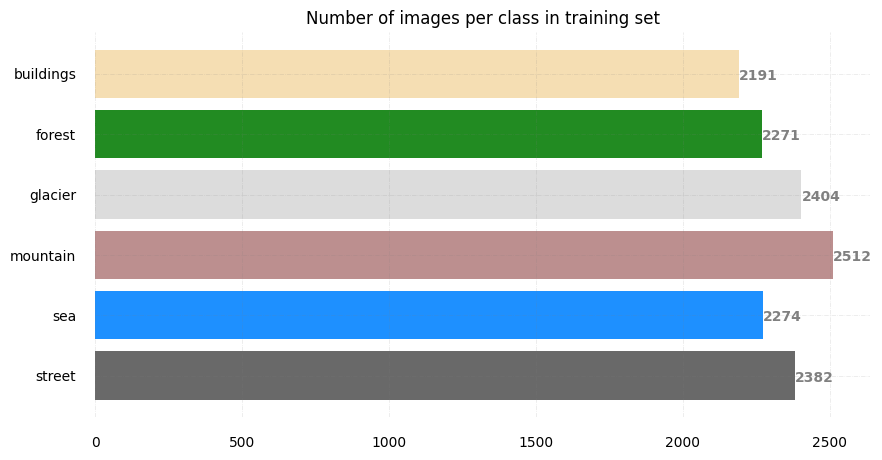

In [ ]:
import pickle

with open("/gdrive/My Drive/Kaggle/classes_frequency_dict.pkl", "rb") as infile:
  classes_frequency_dict = pickle.load(infile)

fig, ax = plt.subplots(figsize=(10, 5))

colors_dict = {
    'street': 'dimgray',
    'sea': 'dodgerblue',
    'forest': 'forestgreen',
    'glacier': 'gainsboro',
    'mountain': 'rosybrown',
    'buildings': 'wheat'
}

labels_list = list(classes_frequency_dict.keys())
labels_frequency_list = list(classes_frequency_dict.values())
plt.barh(labels_list, labels_frequency_list, color=[colors_dict[label] for label in labels_list])
plt.title('Number of images per class in training set')
ax.xaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 10)

ax.yaxis.set_ticks_position('none')
ax.yaxis.set_tick_params(pad = 10)

ax.invert_yaxis()
ax.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)

for spline in ['top', 'left', 'right', 'bottom']:
    ax.spines[spline].set_visible(False)

for patch in ax.patches:
    plt.text(patch.get_width()+0.2, patch.get_y()+0.5,
                   str(round((patch.get_width()), 2)),
                   fontsize = 10, fontweight ='bold',
                   color ='grey')
plt.savefig(f'/gdrive/My Drive/Kaggle/plots/bar plots/bar_plot_classes.png', transparent=True)

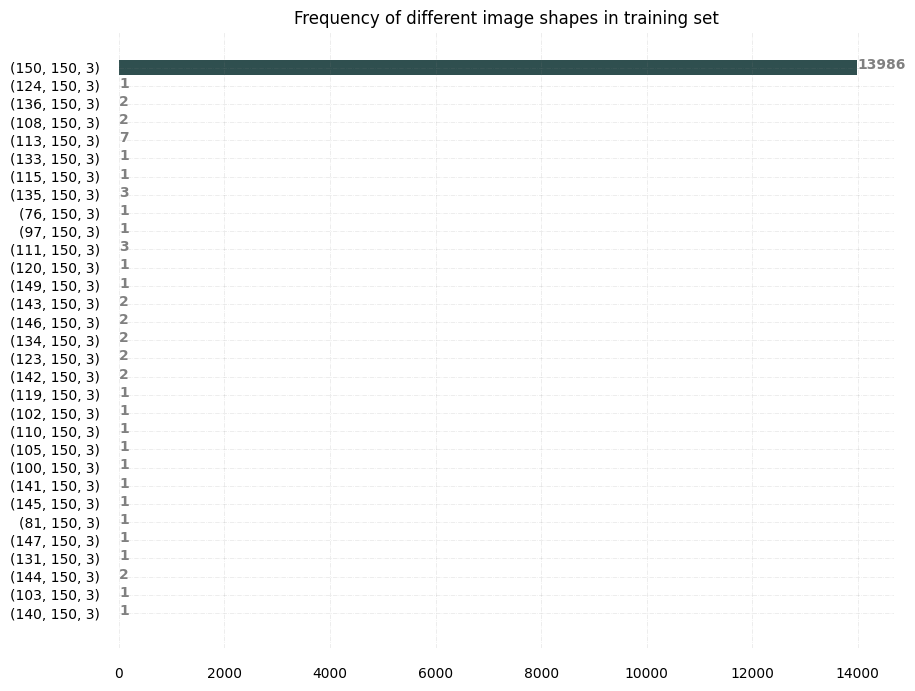

In [ ]:
import pickle

with open("/gdrive/My Drive/Kaggle/image_shapes_frequency_dict.pkl", "rb") as infile:
  image_shapes_frequency_dict = pickle.load(infile)

fig, ax = plt.subplots(figsize=(10, 8))

shapes_list = list(image_shapes_frequency_dict.keys())
shapes_frequency_list = list(image_shapes_frequency_dict.values())
plt.barh(shapes_list, shapes_frequency_list, color='darkslategrey')
plt.title('Frequency of different image shapes in training set')
ax.xaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 10)

ax.yaxis.set_ticks_position('none')
ax.yaxis.set_tick_params(pad = 10)

ax.invert_yaxis()
ax.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)

for spline in ['top', 'left', 'right', 'bottom']:
    ax.spines[spline].set_visible(False)

for patch in ax.patches:
    plt.text(patch.get_width()+0.2, patch.get_y()+0.5,
                   str(round((patch.get_width()), 2)),
                   fontsize = 10, fontweight ='bold',
                   color ='grey')
plt.savefig('/gdrive/My Drive/Kaggle/plots/bar plots/bar_plot_shapes.png', transparent=True)

## B. Creating ```X_train``` and ```y_train```

Since we have created the ```train.csv``` file, we are now ready to load the images of the train set and convert them to ```X_train``` and ```y_train```. The latter are the input and labels respectively that we are going to use to train the models.

In [ ]:
X_train = []
y_train = []
desired_shape = (150, 150, 3)
nof_training_samples = len(train_data)

for row in range(nof_training_samples):
  image_array = np.array(plt.imread(train_data['filepath'][row]))
  image_shape = np.shape(image_array)
  if image_shape[0] != desired_shape[0]:
    label= train_data['label'][row]
    continue
  flattened_image_array = np.reshape(a=image_array, newshape=desired_shape[0] * desired_shape[1] * desired_shape[2])
  X_train.append(flattened_image_array)
  y_train.append(train_data['label'][row])

print(np.shape(X_train))
print(np.shape(y_train))

(13986, 67500)
(13986,)


In [ ]:
path = '/gdrive/My Drive/Kaggle/seg_test/seg_test/'
all_files_list = get_file_list(path)
print(np.shape(all_files_list))
all_files_list[0:5]

(3000, 2)


[['/gdrive/My Drive/Kaggle/seg_test/seg_test/buildings/20140.jpg',
  'buildings'],
 ['/gdrive/My Drive/Kaggle/seg_test/seg_test/buildings/20177.jpg',
  'buildings'],
 ['/gdrive/My Drive/Kaggle/seg_test/seg_test/buildings/20064.jpg',
  'buildings'],
 ['/gdrive/My Drive/Kaggle/seg_test/seg_test/buildings/20186.jpg',
  'buildings'],
 ['/gdrive/My Drive/Kaggle/seg_test/seg_test/buildings/20083.jpg',
  'buildings']]

(150, 150, 3)


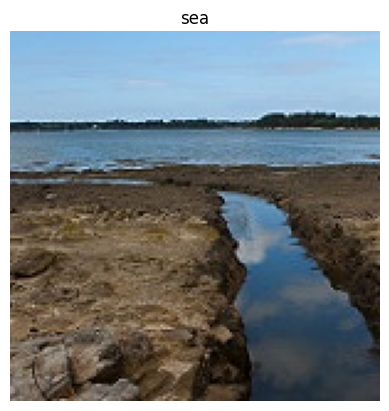

In [ ]:
# visualizing a random image of the test set to ensure
# that everything is alright

import random

random_index = random.randint(0, len(all_files_list) - 1)

image_path = all_files_list[random_index][0]
label = all_files_list[random_index][1]
image_array = plt.imread(image_path)
print(image_array.shape)
plt.imshow(image_array)
plt.axis('off')
plt.title(label)
plt.show()

In [ ]:
test_data = pd.DataFrame(data = all_files_list, columns=['filepath', 'label_verbose'])
pd.set_option('display.max_colwidth', None)
test_data.head()

,filepath,label_verbose
0,/gdrive/My Drive/Kaggle/seg_test/seg_test/buildings/20140.jpg,buildings
1,/gdrive/My Drive/Kaggle/seg_test/seg_test/buildings/20177.jpg,buildings
2,/gdrive/My Drive/Kaggle/seg_test/seg_test/buildings/20064.jpg,buildings
3,/gdrive/My Drive/Kaggle/seg_test/seg_test/buildings/20186.jpg,buildings
4,/gdrive/My Drive/Kaggle/seg_test/seg_test/buildings/20083.jpg,buildings


In [ ]:
test_data['label'] = test_data['label_verbose'].map(labels_dict)

test_data.to_csv('/gdrive/My Drive/Kaggle/test.csv',index=False)

NameError: ignored

In [4]:
labels_list = [
    "buildings",
    "forest",
    "glacier",
    "mountain",
    "sea",
    "street"
]

test_data = pd.read_csv('/gdrive/My Drive/Kaggle/test.csv')
test_data = test_data.sample(frac=1., random_state=22)
test_data.head(10)

,filepath,label_verbose,label
1198,/gdrive/My Drive/Kaggle/seg_test/seg_test/glac...,glacier,2
1800,/gdrive/My Drive/Kaggle/seg_test/seg_test/moun...,mountain,3
2196,/gdrive/My Drive/Kaggle/seg_test/seg_test/sea/...,sea,4
2462,/gdrive/My Drive/Kaggle/seg_test/seg_test/sea/...,sea,4
1699,/gdrive/My Drive/Kaggle/seg_test/seg_test/moun...,mountain,3
2143,/gdrive/My Drive/Kaggle/seg_test/seg_test/sea/...,sea,4
570,/gdrive/My Drive/Kaggle/seg_test/seg_test/fore...,forest,1
1400,/gdrive/My Drive/Kaggle/seg_test/seg_test/glac...,glacier,2
1230,/gdrive/My Drive/Kaggle/seg_test/seg_test/glac...,glacier,2
246,/gdrive/My Drive/Kaggle/seg_test/seg_test/buil...,buildings,0


## C. Creating ```X_test``` and ```y_test```

Since we have created the ```test.csv``` file, we are now ready to load the images of the train set and convert them to ```X_test``` and ```y_test```. The latter are the input and labels respectively that we are going to use to test (evaluate the performance) of the models we have trained.

In [5]:
X_test = []
y_test = []
desired_shape = (150, 150, 3)
nof_testing_samples = len(test_data)

for row in range(nof_testing_samples):
  image_array = np.array(plt.imread(test_data['filepath'][row]))
  image_shape = np.shape(image_array)
  if image_shape[0] != desired_shape[0]:
    label= test_data['label'][row]
    print(f'found anomaly in line {str(row)} of class {labels_list[label]}')
    continue
  flattened_image_array = np.reshape(a=image_array, newshape=desired_shape[0] * desired_shape[1] * desired_shape[2])
  X_test.append(flattened_image_array)
  y_test.append(test_data['label'][row])

print(np.shape(X_test))
print(np.shape(y_test))

found anomaly in line 641 of class forest
found anomaly in line 1085 of class glacier
found anomaly in line 1098 of class glacier
found anomaly in line 1128 of class glacier
found anomaly in line 1290 of class glacier
found anomaly in line 1713 of class mountain
found anomaly in line 1794 of class mountain
(2993, 67500)
(2993,)


In [7]:
# we create a dictionary containing the frequency of each class
# the goal is to plot the frequencies in a bar plot

classes_frequency_dict = {label: 0 for label in labels_list}
image_shapes_frequency_dict = {}

for row in range(len(test_data)):
  label_verbose = test_data['label_verbose'][row]
  classes_frequency_dict[label_verbose] += 1

  image_array = plt.imread(test_data['filepath'][row])
  image_shape_string = str(image_array.shape)
  image_shapes_frequency_dict[image_shape_string] = 1 if image_shape_string not in image_shapes_frequency_dict else image_shapes_frequency_dict[image_shape_string] + 1

print(classes_frequency_dict)
print(image_shapes_frequency_dict)

{'buildings': 437, 'forest': 474, 'glacier': 553, 'mountain': 525, 'sea': 510, 'street': 501}
{'(150, 150, 3)': 2993, '(141, 150, 3)': 1, '(110, 150, 3)': 1, '(149, 150, 3)': 1, '(76, 150, 3)': 1, '(72, 150, 3)': 1, '(131, 150, 3)': 1, '(81, 150, 3)': 1}


In [8]:
import pickle

with open("/gdrive/My Drive/Kaggle/classes_frequency_dict_test.pkl", "wb") as outfile:
  pickle.dump(classes_frequency_dict, outfile)

with open("/gdrive/My Drive/Kaggle/image_shapes_frequency_dict_test.pkl", "wb") as outfile:
  pickle.dump(image_shapes_frequency_dict, outfile)

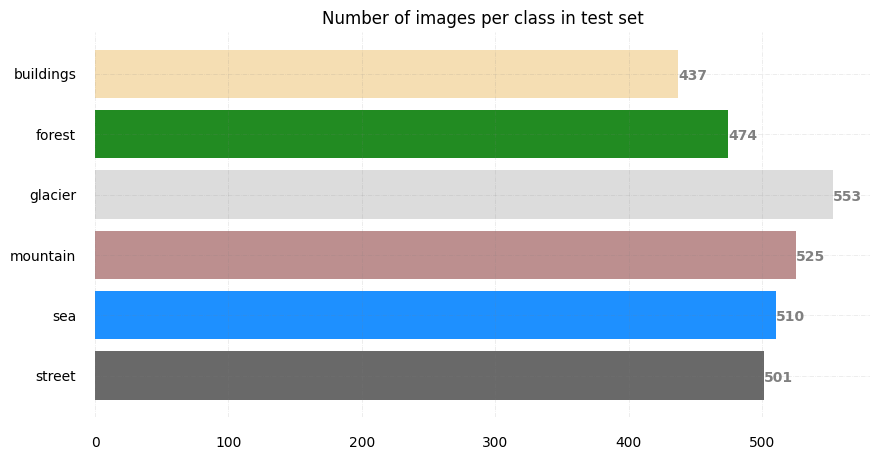

In [9]:
import pickle

with open("/gdrive/My Drive/Kaggle/classes_frequency_dict_test.pkl", "rb") as infile:
  classes_frequency_dict = pickle.load(infile)

fig, ax = plt.subplots(figsize=(10, 5))

colors_dict = {
    'street': 'dimgray',
    'sea': 'dodgerblue',
    'forest': 'forestgreen',
    'glacier': 'gainsboro',
    'mountain': 'rosybrown',
    'buildings': 'wheat'
}

labels_list = list(classes_frequency_dict.keys())
labels_frequency_list = list(classes_frequency_dict.values())
plt.barh(labels_list, labels_frequency_list, color=[colors_dict[label] for label in labels_list])
plt.title('Number of images per class in test set')
ax.xaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 10)

ax.yaxis.set_ticks_position('none')
ax.yaxis.set_tick_params(pad = 10)

ax.invert_yaxis()
ax.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)

for spline in ['top', 'left', 'right', 'bottom']:
    ax.spines[spline].set_visible(False)

for patch in ax.patches:
    plt.text(patch.get_width()+0.2, patch.get_y()+0.5,
                   str(round((patch.get_width()), 2)),
                   fontsize = 10, fontweight ='bold',
                   color ='grey')
plt.savefig(f'/gdrive/My Drive/Kaggle/plots/bar plots/bar_plot_classes_test.png', transparent=True)

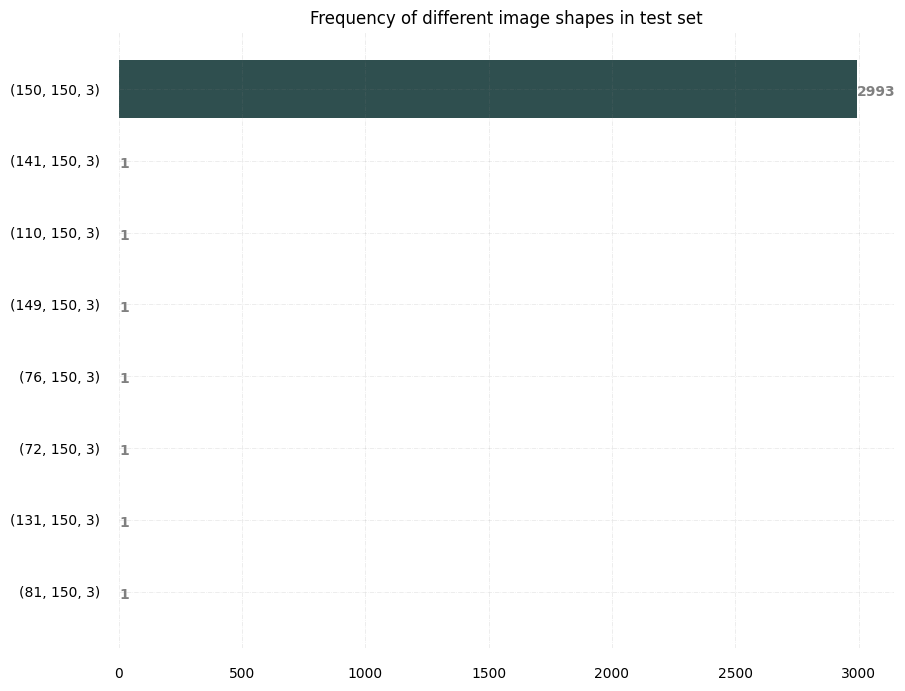

In [10]:
import pickle

with open("/gdrive/My Drive/Kaggle/image_shapes_frequency_dict_test.pkl", "rb") as infile:
  image_shapes_frequency_dict = pickle.load(infile)

fig, ax = plt.subplots(figsize=(10, 8))

shapes_list = list(image_shapes_frequency_dict.keys())
shapes_frequency_list = list(image_shapes_frequency_dict.values())
plt.barh(shapes_list, shapes_frequency_list, color='darkslategrey')
plt.title('Frequency of different image shapes in test set')
ax.xaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 10)

ax.yaxis.set_ticks_position('none')
ax.yaxis.set_tick_params(pad = 10)

ax.invert_yaxis()
ax.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)

for spline in ['top', 'left', 'right', 'bottom']:
    ax.spines[spline].set_visible(False)

for patch in ax.patches:
    plt.text(patch.get_width()+0.2, patch.get_y()+0.5,
                   str(round((patch.get_width()), 2)),
                   fontsize = 10, fontweight ='bold',
                   color ='grey')
plt.savefig('/gdrive/My Drive/Kaggle/plots/bar plots/bar_plot_shapes_test.png', transparent=True)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from joblib import dump, load

knn_classifier1 = KNeighborsClassifier(n_neighbors=1)
knn_classifier1.fit(X_train, y_train)
dump(knn_classifier1, '/gdrive/My Drive/Kaggle/classifiers/knn1.joblib')

knn_classifier3 = KNeighborsClassifier(n_neighbors=3)
knn_classifier3.fit(X_train, y_train)
dump(knn_classifier3, '/gdrive/My Drive/Kaggle/classifiers/knn3.joblib')

nc_classifier = NearestCentroid()
nc_classifier.fit(X_train, y_train)
dump(nc_classifier, '/gdrive/My Drive/Kaggle/classifiers/nc.joblib')

['/gdrive/My Drive/Kaggle/classifiers/mlp.joblib']

In [ ]:
from sklearn.metrics import classification_report
y_pred_knn1 = knn_classifier1.predict(X_test)
y_pred_knn3 = knn_classifier3.predict(X_test)
y_pred_nc = nc_classifier.predict(X_test)

print('Knn 1')
print(classification_report(y_test, y_pred_knn1))
print()

print('Knn 3')
print(classification_report(y_test, y_pred_knn3))
print()

print('NC')
print(classification_report(y_test, y_pred_nc))
print()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from joblib import dump, load
from sklearn.metrics import classification_report

knn_classifier1 = load('/gdrive/My Drive/Kaggle/classifiers/knn1.joblib')
y_pred_knn1 = knn_classifier1.predict(X_test)
print('KNN 1')
print(classification_report(y_test, y_pred_knn1))
print()

KNN 1
              precision    recall  f1-score   support

           0       0.48      0.03      0.06       437
           1       0.62      0.30      0.40       473
           2       0.41      0.36      0.38       549
           3       0.34      0.72      0.46       523
           4       0.24      0.49      0.33       510
           5       0.68      0.16      0.25       501

    accuracy                           0.35      2993
   macro avg       0.46      0.34      0.31      2993
weighted avg       0.46      0.35      0.32      2993




In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from joblib import dump, load
from sklearn.metrics import classification_report

knn_classifier3 = load('/gdrive/My Drive/Kaggle/classifiers/knn3.joblib')
y_pred_knn3 = knn_classifier1.predict(X_test)
print('KNN 3')
print(classification_report(y_test, y_pred_knn3))
print()

KNN 3
              precision    recall  f1-score   support

           0       0.48      0.03      0.06       437
           1       0.62      0.30      0.40       473
           2       0.41      0.36      0.38       549
           3       0.34      0.72      0.46       523
           4       0.24      0.49      0.33       510
           5       0.68      0.16      0.25       501

    accuracy                           0.35      2993
   macro avg       0.46      0.34      0.31      2993
weighted avg       0.46      0.35      0.32      2993




In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from joblib import dump, load
from sklearn.metrics import classification_report

nc_classifier = load('/gdrive/My Drive/Kaggle/classifiers/nc.joblib')
y_pred_nc = nc_classifier.predict(X_test)
print('Nearest Centroid')
print(classification_report(y_test, y_pred_nc))
print()

Nearest Centroid
              precision    recall  f1-score   support

           0       0.33      0.22      0.27       437
           1       0.53      0.75      0.62       473
           2       0.44      0.57      0.50       549
           3       0.43      0.60      0.50       523
           4       0.34      0.12      0.18       510
           5       0.45      0.37      0.41       501

    accuracy                           0.44      2993
   macro avg       0.42      0.44      0.41      2993
weighted avg       0.42      0.44      0.42      2993




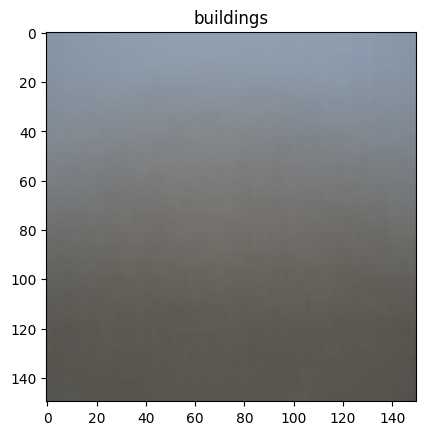

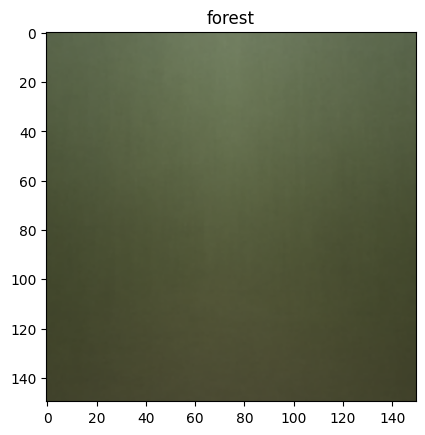

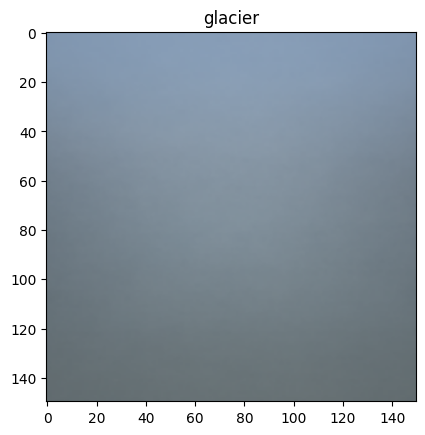

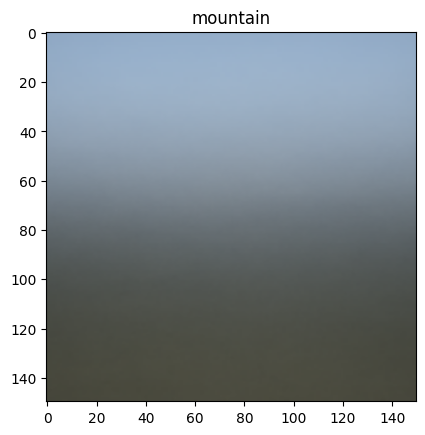

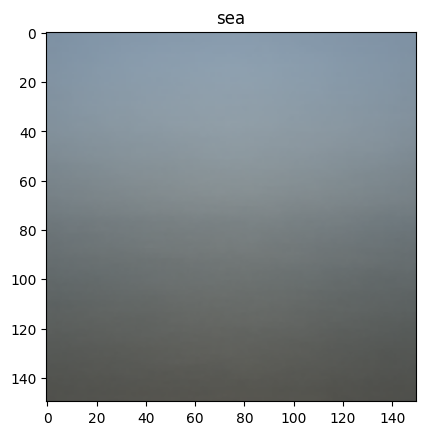

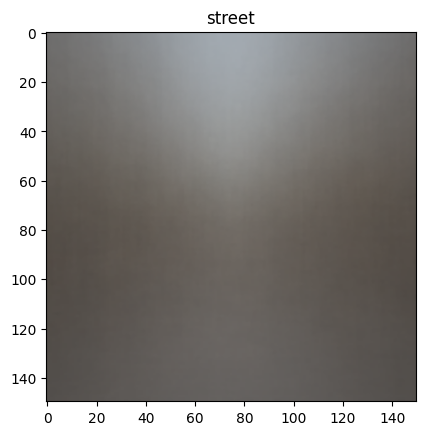

<Figure size 640x480 with 0 Axes>

In [ ]:
centroids = nc_classifier.centroids_

for index, centroid in enumerate(centroids):
  centroid = centroid.reshape((150, 150, 3)).astype(int)
  plt.imshow(centroid)
  plt.title(labels_list[index])
  plt.show()
  plt.savefig(f'/gdrive/My Drive/Kaggle/plots/{index}.png')